In [1]:
import os, csv, sys, cv2, random, math
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Con quale dataset vuoi classificare?
    #"Personal43Classes": PersonalCNN addestrata nel progetto di MQI su un dataset generico con 43 classi
    #"PersonalDITS59Classes": PersonalCNN addestrata con il dataset italiano di cartelli stradali con 59 classi
    #"PersonalGTSDB43Classes": PersonalCNN addestrata con il dataset tedesco GTSDB di cartelli stradali con 43 classi
    #"PersonalMOD-DITS59Classes": PersonalCNN addestrata con il dataset italiano di cartelli stradali con 59 classi
            #modificato con più samples per classe. L'accuracy è lievemente più alta rispetto al caso precedente
datasetScelto = "Personal43Classes"

if(datasetScelto=="Personal43Classes"):
    pathLabels="reteAddestrata/labels43Classes.csv"
    reteCaricata="reteAddestrata/PersonalCNN-43Classes-15Epoche-EarlyStoppingSI-TrainAgSI-TestAgSI.h5"
    modello_cartelli = load_model(reteCaricata, custom_objects={'leaky_relu': tf.nn.leaky_relu})
    numeroClassi=43
elif(datasetScelto=="PersonalGTSDB"):
    pathLabels="reteAddestrata/GTSDBlabels43Classes.csv"
    reteCaricata="reteAddestrata/PersonalCNN-GTSDB43Classes-15Epoche-EarlyStoppingSI-TrainAgNO-TestAgNO.h5"
    modello_cartelli = load_model(reteCaricata, custom_objects={'leaky_relu': tf.nn.leaky_relu})
    numeroClassi=43
elif(datasetScelto=="Personal59Classes"):
    pathLabels="reteAddestrata/labels59Classes.csv"
    reteCaricata="reteAddestrata/PersonalCNN-59Classes-30Epoche-EarlyStoppingSI-TrainAgSI-TestAgSI_split12.h5"
    modello_cartelli = load_model(reteCaricata, custom_objects={'leaky_relu': tf.nn.leaky_relu})
    numeroClassi=59
elif(datasetScelto=="MODPersonal59Classes"):
    pathLabels="reteAddestrata/labels59Classes.csv"
    reteCaricata="reteAddestrata/PersonalCNN-MOD-15Epoche-EarlyStoppingSI-TrainAgSI-TestAgNO.h5"
    modello_cartelli = load_model(reteCaricata, custom_objects={'leaky_relu': tf.nn.leaky_relu})
    numeroClassi=59
else:
    raise SystemExit("Dataset non riconosciuto")

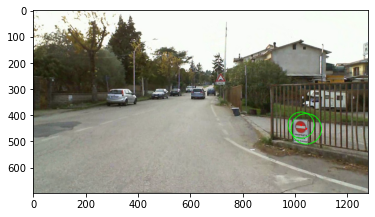

In [3]:
origine = "test_images/"
nomeImmDaCaricare = "264.png"

imgOrig = cv2.imread(origine+nomeImmDaCaricare)
imgOrig = cv2.cvtColor(imgOrig, cv2.COLOR_BGR2RGB)

img = cv2.imread(origine+nomeImmDaCaricare, 0)
img = cv2.medianBlur(img,5)
cimg = imgOrig.copy()

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1=300, param2=50, minRadius=25, maxRadius=350)

# ensure at least one circle was found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        # draw the outer circle
        cv2.circle(cimg, (x, y), r, (0,255,0), 2)
        # draw the center of the circle
        cv2.circle(cimg, (x, y), 2, (255,0,0), 3)
        # draw rectangle out of the circle
        #cv2.rectangle(cimg, (x - r, y - r), (x + r, y + r), (0, 128, 255), 2)
    plt.imshow(cimg)
    # salvataggio su file dell'immagine. Necessario cambiare l'ordine dei colori e alzare la qualità del salvataggio
    #cv2.imwrite('models/esempioFiltroCerchi'+nomeImmDaCaricare+"-"+datasetScelto+'.png', cv2.cvtColor(cimg, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 100])
else:
    print("Nessuno cerchio individuato")    

In [4]:
cropped = []

if circles is not None:
    indexTemp = 0;
    #creo nuovi temp
    for (x, y, r) in circles:
        #Inserisco con vari dimensioni di taglio: Il raggio stesso, il doppio del raggio individuato e la metà
        nuovoRiconoscimento = imgOrig.copy()
        altezzaImmagine = nuovoRiconoscimento.shape[0]
        larghezzaImmagine = nuovoRiconoscimento.shape[1]
        #Verifico che il cerchio individuato non vada fuori immagine prima di tagliare:
        if(y-r>0 and x-r>0 and y+r<altezzaImmagine and x+r<larghezzaImmagine):
            arr_crop = nuovoRiconoscimento[(y-r):(y+r), (x-r):(x+r)]  
            cropped.append(arr_crop)
        #Verifico che la metà cerchio individuato non vada fuori immagine prima di tagliare:
        if(y-int(r/2)>0 and x-int(r/2)>0 and y+int(r/2)<altezzaImmagine and x+int(r/2)<larghezzaImmagine):
            arr_crop = nuovoRiconoscimento[(y-int(r/2)):(y+int(r/2)), (x-int(r/2)):(x+int(r/2))]  
            cropped.append(arr_crop)
        #Verifico che il doppio del cerchio individuato non vada fuori immagine prima di tagliare:
        if(y-2*r>0 and x-2*r>0 and y+2*r<altezzaImmagine and x+2*r<larghezzaImmagine):
            arr_crop = nuovoRiconoscimento[(y-2*r):(y+2*r), (x-2*r):(x+2*r)]  
            cropped.append(arr_crop)
        indexTemp+=3
    if(len(cropped)>70):
        print("Sono stati ritagliati troppi cerchi. Probabilmente i valori threshold non sono adeguati, quindi elimino le crop svolte.")
        cropped = []
    elif(len(cropped)<indexTemp):
        print("Sono stati fatti "+str(len(cropped))+" crop su "+str(indexTemp)+" perché alcuni tagli sarebbero andati fuori immagine.")
    else:
        print("Tutti i crop effettuati con successo.")
else:
    print("Nessun crop svolto in quanto non sono stati individuati cerchi.")

Tutti i crop effettuati con successo.


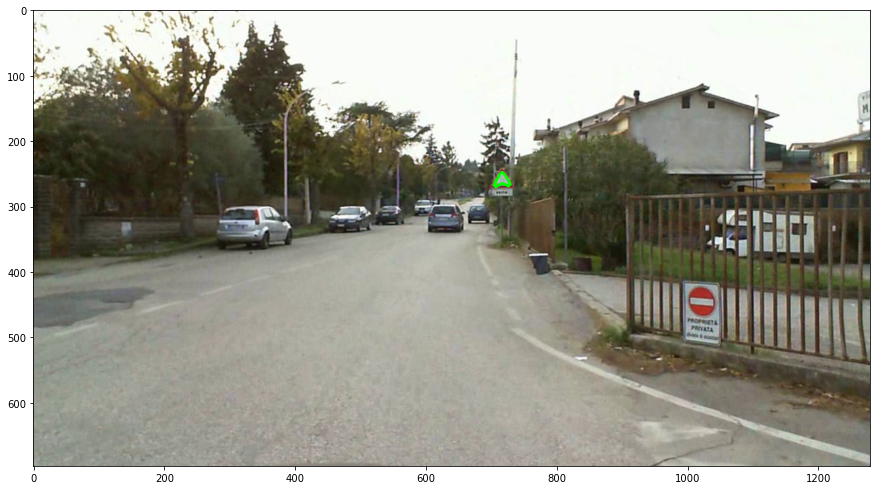

In [21]:
image_obj = cv2.imread(origine+nomeImmDaCaricare)

image_obj = cv2.cvtColor(image_obj, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_obj, cv2.COLOR_RGB2GRAY)

kernel = np.ones((4, 4), np.uint8)
dilation = cv2.dilate(gray, kernel, iterations=1)

blur = cv2.GaussianBlur(dilation, (5, 5), 0)
coordinates = []

thresh1 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 1331, 2)
thresh2 = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 14641, 2)

###################   Now finding Contours   ###################
#provo con una prima threshold che in genere trova triangoli più piccoli e lontani
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    #[point_x, point_y, width, height] = cv2.boundingRect(cnt)
    approx = cv2.approxPolyDP(cnt, 0.07 * cv2.arcLength(cnt, True), True)
    if len(approx) == 3:
        xPrimoPunto=approx[0][0][0]
        yPrimoPunto=approx[0][0][1]
        xSecondoPunto=approx[1][0][0]
        ySecondoPunto=approx[1][0][1]
        xTerzoPunto=approx[2][0][0]
        yTerzoPunto=approx[2][0][1]
        #Calcolo la distanza con la formula: rj=sqrt((xi-xj)^2 + (yi-yj)^2)
        r1=math.sqrt(pow((xPrimoPunto-xSecondoPunto), 2)+pow((yPrimoPunto-ySecondoPunto), 2))
        r2=math.sqrt(pow((xPrimoPunto-xTerzoPunto), 2)+pow((yPrimoPunto-yTerzoPunto), 2))
        r3=math.sqrt(pow((xSecondoPunto-xTerzoPunto), 2)+pow((ySecondoPunto-yTerzoPunto), 2))
        #Verifico che ogni segmento sia almeno 20 pixel per non avere falsi triangoli troppi piccoli
        if(r1>20 and r2>20 and r3>20):
            rapp1=r1/r2
            rapp2=r1/r3
            rapp3=r2/r3
            #Confronto i rapporti per trovare i triangoli
            if(0.8<rapp1<1.2 and 0.8<rapp2<1.2 and 0.8<rapp3<1.2): 
                controllo=1
                #Applico un filtro per controllare che triangoli simili non siano già stati inseriti
                for (p1, p2, p3, lat1, lat2, lat3) in coordinates:
                    if((-20<p1[0]-approx[0][0][0]<20 and -10<p1[1]-approx[0][0][1]<20) and
                      (-20<p2[0]-approx[1][0][0]<20 and -10<p2[1]-approx[1][0][1]<20) and
                      (-20<p3[0]-approx[2][0][0]<20 and -10<p3[1]-approx[2][0][1]<20)):
                        controllo=0
                if(controllo==1):
                    coordinates.append([approx[0][0], approx[1][0], approx[2][0], r1, r2, r3])
                    cv2.drawContours(image_obj, [cnt], 0, (0, 255, 0), 3)
                    #cv2.drawContours(cimg, [cnt], 0, (0, 255, 0), 3)

#provo con una seconda threshold che in genere trova triangoli più grandi e vicini
contours, hierarchy = cv2.findContours(thresh2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    #[point_x, point_y, width, height] = cv2.boundingRect(cnt)
    approx = cv2.approxPolyDP(cnt, 0.07 * cv2.arcLength(cnt, True), True)
    if len(approx) == 3:
        xPrimoPunto=approx[0][0][0]
        yPrimoPunto=approx[0][0][1]
        xSecondoPunto=approx[1][0][0]
        ySecondoPunto=approx[1][0][1]
        xTerzoPunto=approx[2][0][0]
        yTerzoPunto=approx[2][0][1]
        #Calcolo la distanza con la formula: rj=sqrt((xi-xj)^2 + (yi-yj)^2)
        r1=math.sqrt(pow((xPrimoPunto-xSecondoPunto), 2)+pow((yPrimoPunto-ySecondoPunto), 2))
        r2=math.sqrt(pow((xPrimoPunto-xTerzoPunto), 2)+pow((yPrimoPunto-yTerzoPunto), 2))
        r3=math.sqrt(pow((xSecondoPunto-xTerzoPunto), 2)+pow((ySecondoPunto-yTerzoPunto), 2))
        #Verifico che ogni segmento sia almeno 20 pixel per non avere falsi triangoli troppi piccoli
        if(r1>20 and r2>20 and r3>20):
            rapp1=r1/r2
            rapp2=r1/r3
            rapp3=r2/r3
            #Confronto i triangoli con quelli già segnati, così da evitare doppioni
            if(0.8<rapp1<1.2 and 0.8<rapp2<1.2 and 0.8<rapp3<1.2): 
                controllo=1
                #Applico un filtro per controllare che triangoli simili non siano già stati inseriti
                for (p1, p2, p3, lat1, lat2, lat3) in coordinates:
                    if((-20<p1[0]-approx[0][0][0]<20 and -10<p1[1]-approx[0][0][1]<20) and
                      (-20<p2[0]-approx[1][0][0]<20 and -10<p2[1]-approx[1][0][1]<20) and
                      (-20<p3[0]-approx[2][0][0]<20 and -10<p3[1]-approx[2][0][1]<20)):
                        controllo=0
                if(controllo==1):
                    coordinates.append([approx[0][0], approx[1][0], approx[2][0], r1, r2, r3])
                    cv2.drawContours(image_obj, [cnt], 0, (0, 255, 0), 3)
                    #cv2.drawContours(cimg, [cnt], 0, (0, 255, 0), 3)
                
#cv2.imwrite("test_images/result.png", image_obj)
plt.figure(figsize=(15, 15))
plt.imshow(image_obj)
#cv2.imwrite('models/esempioFiltroTriang'+nomeImmDaCaricare+"-"+datasetScelto+'.png', cv2.cvtColor(image_obj, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 100])
#cv2.imwrite('models/esempio2Filtri-'+nomeImmDaCaricare+"-"+datasetScelto+'.png', cv2.cvtColor(cimg, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 100])

In [6]:
def findCircleAroundTriangle(x1, y1, x2, y2, x3, y3):
    x12 = x1 - x2 
    x13 = x1 - x3 
    y12 = y1 - y2 
    y13 = y1 - y3 
    y31 = y3 - y1 
    y21 = y2 - y1 
    x31 = x3 - x1 
    x21 = x2 - x1
    # x1^2 - x3^2 
    sx13 = pow(x1, 2) - pow(x3, 2)
    #y1^2 - y3^2 
    sy13 = pow(y1, 2) - pow(y3, 2) 
    sx21 = pow(x2, 2) - pow(x1, 2); 
    sy21 = pow(y2, 2) - pow(y1, 2);  
    f = ((sx13*x12)+(sy13*x12)+(sx21*x13)+(sy21*x13)) / (2*((y31*x12)-(y21*x13))) 
    g = ((sx13*y12)+(sy13*y12)+(sx21*y13)+(sy21*y13)) / (2*((x31*y12)-(x21*y13)))  
    c = -pow(x1, 2) -pow(y1, 2) -2*g*x1 -2*f*y1  
    # eqn of circle be:   x^2 + y^2 + 2*g*x + 2*f*y + c = 0 
    # where centre is     (h = -g, k = -f) 
    # and radius r as     r^2 = h^2 + k^2 - c 
    centroX = -g 
    centroY = -f
    sqr_of_r = (centroX*centroX)+(centroY*centroY)-c 
    # r is the radius 
    r = math.sqrt(sqr_of_r)  
    #con la conversione "int" si passa da float ad intero
    return int(centroX), int(centroY), (int(r)+2)

In [7]:
indexTemp = 0;
exDimensioneCropped = len(cropped)
if coordinates:
    #creo nuovi temp
    for (p1, p2, p3, lat1, lat2, lat3) in coordinates:
        #Inserisco con vari dimensioni di taglio: Il raggio stesso, il doppio del raggio individuato e la metà
        nuovoRiconoscimento = imgOrig.copy()
        x, y, r = findCircleAroundTriangle(p1[0], p1[1], p2[0], p2[1], p3[0], p3[1])
        r=r+10
        altezzaImmagine = nuovoRiconoscimento.shape[0]
        larghezzaImmagine = nuovoRiconoscimento.shape[1]
        #Verifico che il cerchio individuato non vada fuori immagine prima di tagliare:
        if(y-r>0 and x-r>0 and y+r<altezzaImmagine and x+r<larghezzaImmagine):
            arr_crop = nuovoRiconoscimento[(y-r):(y+r), (x-r):(x+r)]  
            cropped.append(arr_crop)
            indexTemp+=1
    if(len(cropped)-exDimensioneCropped>15):
        print("Sono stati ritagliati troppi triangoli. Probabilmente i valori threshold non sono adeguati, quindi elimino le crop svolte.")
        cropped = cropped[:exDimensioneCropped]
    else:
        print("Sono state effettuati con successo "+str(indexTemp)+" crop.")
else:
    print("Nessun crop svolto in quanto non sono stati individuati triangoli.")

Sono state effettuati con successo 1 crop.


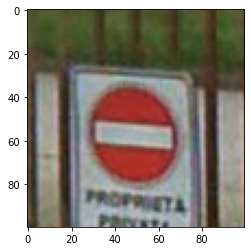

In [8]:
plt.imshow(cropped[0], cmap='gray')
#plt.savefig('models/Cerchio'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')

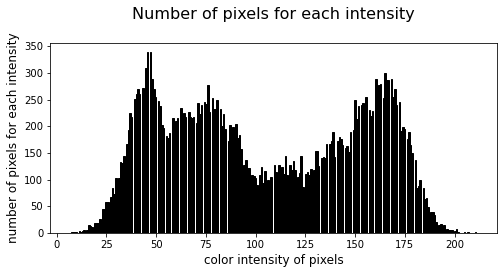

In [9]:
#Imposto la dimensione delle prossime stampe
plt.figure(figsize=(8, 3.5))
plt.xlabel("color intensity of pixels", fontsize=12)
plt.ylabel("number of pixels for each intensity", fontsize=12)
plt.title('Number of pixels for each intensity\n', fontsize=16)
bin_counts, bin_edges, patches = plt.hist(cropped[0].ravel(), bins=256, fc='k', ec='k')
#plt.savefig('models/istogrammaGenericoCerchio-'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')

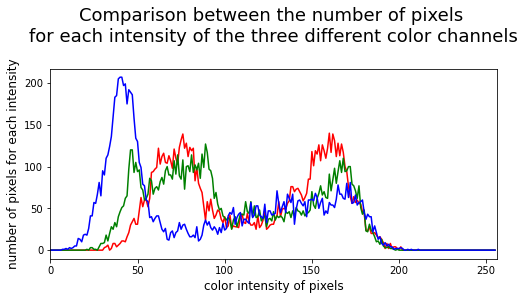

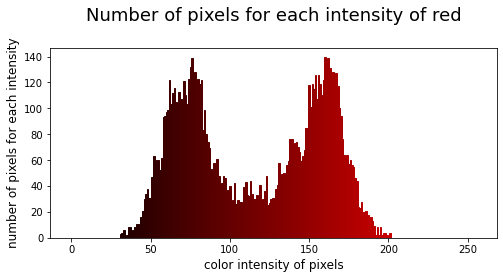

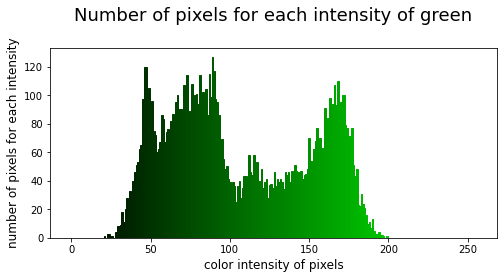

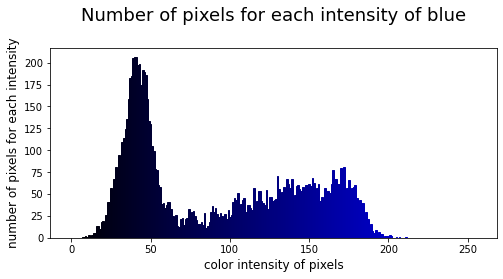

In [10]:
color = ('r','g','b')

#Grafico confronto colori
plt.figure(figsize=(8, 3.5))
for i,col in enumerate(color):
    histr = cv2.calcHist([cropped[0]],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.xlabel("color intensity of pixels", fontsize=12)
plt.ylabel("number of pixels for each intensity", fontsize=12)
plt.title('Comparison between the number of pixels \nfor each intensity of the three different color channels\n', fontsize=18)
#plt.savefig('models/istogrammaCerchioTreColorazioni-'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')
plt.show()

#Grafico colori con miglior rappresentazione dell'intensità
def show_rgb_hist(image):
    for i, c in enumerate(color):
        plt.figure(figsize=(8, 3.5))
        plt.xlabel("color intensity of pixels", fontsize=12)
        plt.ylabel("number of pixels for each intensity", fontsize=12)
        nomeTitolo="Number of pixels for each intensity of "
        histr = cv2.calcHist([image], [i], None, [256], [0, 256])
        if c == 'r':
            colours = [((i/256, 0, 0)) for i in range(0, 256)]
            nomeTitolo+="red\n"
        elif c == 'g':
            colours = [((0, i/256, 0)) for i in range(0, 256)]
            nomeTitolo+="green\n"
        elif c == 'b':
            colours = [((0, 0, i/256)) for i in range(0, 256)]
            nomeTitolo+="blue\n"
        plt.bar(range(0, 256), histr.reshape(256), color=colours, edgecolor=colours, width=1)
        plt.title(nomeTitolo, fontsize=18)
        #plt.savefig('models/istogrammaCerchioCol-'+c+'-'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')
        plt.show()

show_rgb_hist(cropped[0])

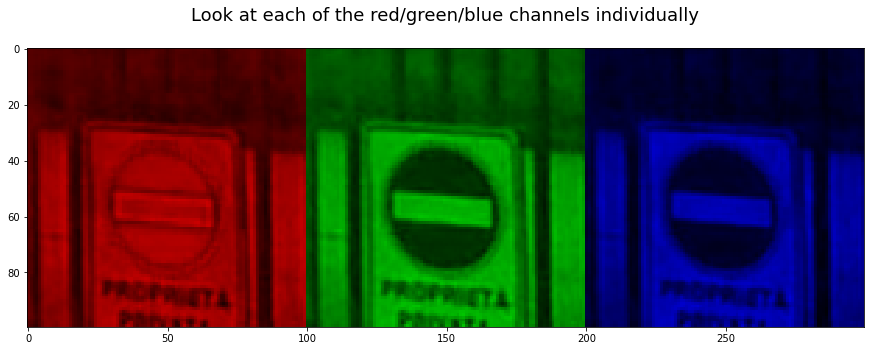

In [11]:
# Show Red/Green/Blue Image
nuovaImmagine = []
for i in [0, 1, 2]:
    colour = cropped[0].copy()
    if i != 0: colour[:,:,0] = 0
    if i != 1: colour[:,:,1] = 0
    if i != 2: colour[:,:,2] = 0
    nuovaImmagine.append(colour)

plt.figure(figsize=(15, 15))
plt.title('Look at each of the red/green/blue channels individually\n', fontsize=18)
plt.imshow(np.hstack(nuovaImmagine), interpolation='nearest')
#plt.savefig('models/istogrammaCircleChannelsIndividually'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')
plt.show()

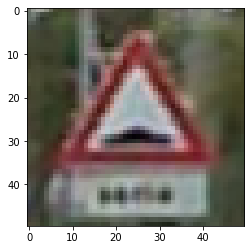

In [12]:
indiceDeiTriangoli=len(cropped)-indexTemp
if(indexTemp==0):
    indiceDeiTriangoli-=1
plt.imshow(cropped[indiceDeiTriangoli], cmap='gray')
#plt.savefig('models/Triangolo'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')

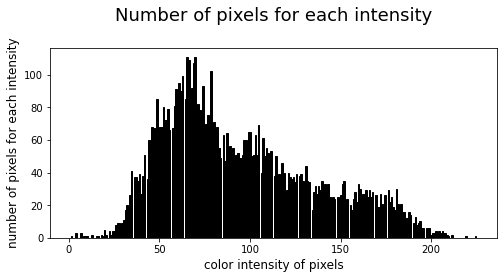

In [13]:
#Imposto la dimensione delle prossime stampe
plt.figure(figsize=(8, 3.5))
plt.xlabel("color intensity of pixels", fontsize=12)
plt.ylabel("number of pixels for each intensity", fontsize=12)
plt.title('Number of pixels for each intensity\n', fontsize=18)
bin_counts, bin_edges, patches = plt.hist(cropped[indiceDeiTriangoli].ravel(), bins=256, fc='k', ec='k')
#plt.savefig('models/istogrammaGenericoTriangolo-'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')

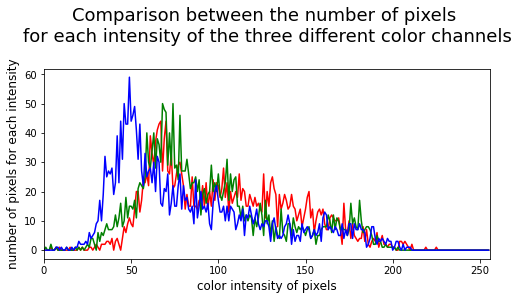

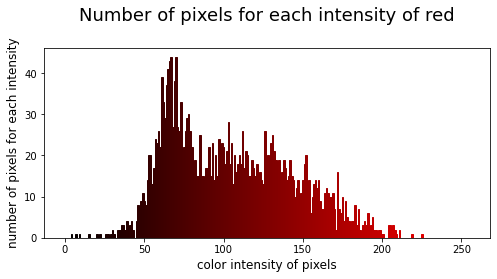

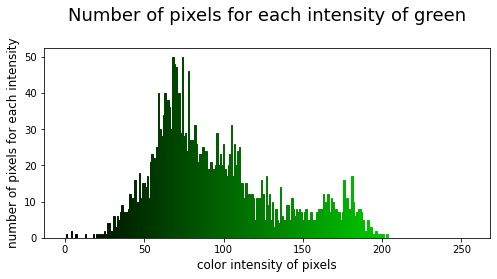

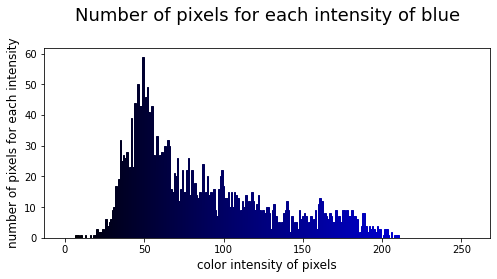

In [14]:
color = ('r','g','b')

#Grafico confronto colori
plt.figure(figsize=(8, 3.5))
for i,col in enumerate(color):
    histr = cv2.calcHist([cropped[indiceDeiTriangoli]],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.xlabel("color intensity of pixels", fontsize=12)
plt.ylabel("number of pixels for each intensity", fontsize=12)
plt.title('Comparison between the number of pixels \nfor each intensity of the three different color channels\n', fontsize=18)
#plt.savefig('models/istogrammaTriangoloTreColorazioni-'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')
plt.show()

#Grafico colori con miglior rappresentazione dell'intensità
def show_rgb_hist(image):
    for i, c in enumerate(color):
        plt.figure(figsize=(8, 3.5))
        plt.xlabel("color intensity of pixels", fontsize=12)
        plt.ylabel("number of pixels for each intensity", fontsize=12)
        nomeTitolo="Number of pixels for each intensity of "
        histr = cv2.calcHist([image], [i], None, [256], [0, 256])
        if c == 'r':
            colours = [((i/256, 0, 0)) for i in range(0, 256)]
            nomeTitolo+="red\n"
        elif c == 'g':
            colours = [((0, i/256, 0)) for i in range(0, 256)]
            nomeTitolo+="green\n"
        elif c == 'b':
            colours = [((0, 0, i/256)) for i in range(0, 256)]
            nomeTitolo+="blue\n"
        plt.bar(range(0, 256), histr.reshape(256), color=colours, edgecolor=colours, width=1)
        plt.title(nomeTitolo, fontsize=18)
        #plt.savefig('models/istogrammaTriangoloCol-'+c+'-'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')
        plt.show()

show_rgb_hist(cropped[indiceDeiTriangoli])

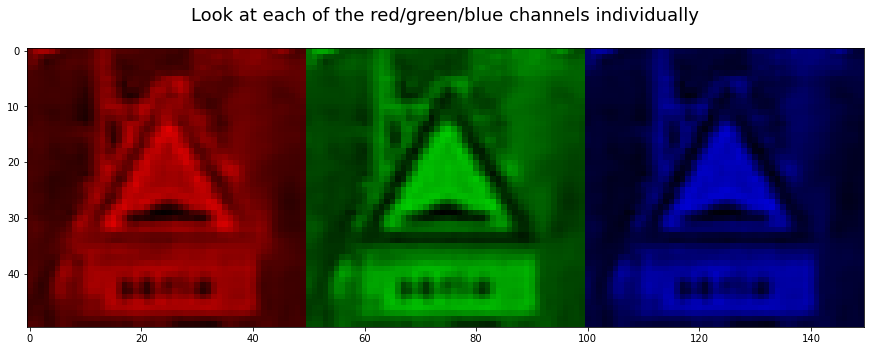

In [15]:
# Show Red/Green/Blue Image
nuovaImmagine = []
for i in [0, 1, 2]:
    colour = cropped[indiceDeiTriangoli].copy()
    if i != 0: colour[:,:,0] = 0
    if i != 1: colour[:,:,1] = 0
    if i != 2: colour[:,:,2] = 0
    nuovaImmagine.append(colour)

plt.figure(figsize=(15, 15))
plt.title('Look at each of the red/green/blue channels individually\n', fontsize=18)
plt.imshow(np.hstack(nuovaImmagine), interpolation='nearest')
#plt.savefig('models/istogrammaTriangleChannelsIndividually'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')
plt.show()

In [16]:
X_test_resized = []
img_height_resized, img_width_resized = 32, 32

def resize_dataset(dataset):
    dataset_resized = []
    for i in range(len(dataset)):
        dataset_resized.append(cv2.resize(dataset[i], dsize=(img_height_resized, img_width_resized), interpolation=cv2.INTER_CUBIC))
    dataset_resized = np.array(dataset_resized)
    return dataset_resized

X_test_resized = resize_dataset(cropped)

print('dimensione test set ridimensionato:',X_test_resized.shape)

dimensione test set ridimensionato: (7, 32, 32, 3)


In [17]:
#Importo i nomi delle classi
with open(pathLabels, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
#elimino elementi delle prime entry che non sono dati utili
data.pop(0)
data.pop(0)
listaNomiClassi = [];
for i in range(len(data)):
    #Divido la riga per poi prendere l'elemento che mi serve
    rigaInEsame = data[i][0].split(";")
    listaNomiClassi+=[rigaInEsame[1]]

Digit: '1' corrisponde a 'Speed limit (30km/h)'
Digit: '17' corrisponde a 'No entry'
Digit: '22' corrisponde a 'Bumpy road'
Digit: '34' corrisponde a 'Turn left ahead'
Digit: '35' corrisponde a 'Ahead only'
Digit: '36' corrisponde a 'Go straight or right'


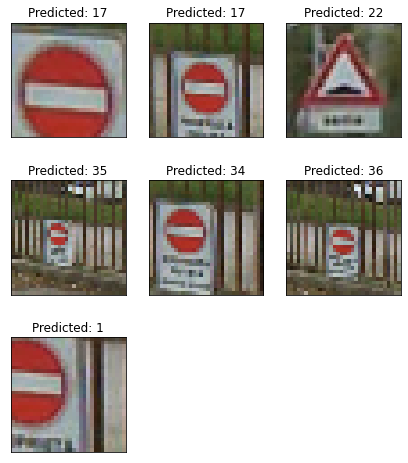

In [18]:
predicted_classes = np.argmax(modello_cartelli.predict(X_test_resized), axis=-1)

indiciPredizioni = np.nonzero(predicted_classes)[0]

#genero indici random per le stampe:
if(len(cropped)<9):
    randomIndex=random.sample(range(len(cropped)), len(cropped))
    rangeFor=len(cropped)
else:
    randomIndex=random.sample(range(len(cropped)), 9)
    rangeFor=9

if(indiciPredizioni.size==0):
    print("Le immagini non sono state assocciate a nessuna classe.")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)
figure_evaluation = plt.figure()

listaClassiCheVerrannoStampate = []
for i in range(rangeFor):
    #Creo la lista di classi e valori che verranno stampate
    if(indiciPredizioni.size>0):
        #In questo primo caso la rete ha ottenuto dei riscontri, quindi si procede per stamparle
        pred=indiciPredizioni[randomIndex[i]]
        valoreDigits=predicted_classes[pred]
        nomeDigits=listaNomiClassi[valoreDigits]
        if [valoreDigits, nomeDigits] not in listaClassiCheVerrannoStampate:
            listaClassiCheVerrannoStampate+=[[valoreDigits, nomeDigits]]
    else:
        #In questo secondo caso la rete NON ha ottenuto dei riscontri, quindi si processeranno stampe vuote
        pred=i
        valoreDigits="-\-"
    #Stampa classica delle digits
    plt.subplot(5,3,i+1)
    plt.imshow(X_test_resized[pred], interpolation='none')
    plt.title("Predicted: {}".format(valoreDigits))
    plt.xticks([])
    plt.yticks([])
    
#Prima stampo le classi presenti, con la corrispondente digits in ordine di digits
for i in range(numeroClassi):
    for j in range(len(listaClassiCheVerrannoStampate)):
        if listaClassiCheVerrannoStampate[j][0]==i:
            print("Digit: '{}' corrisponde a '{}'".format(listaClassiCheVerrannoStampate[j][0], 
                                                          listaClassiCheVerrannoStampate[j][1]))
            
#Stampo i cartelli
plt.savefig('models/risultati-'+nomeImmDaCaricare+"-"+datasetScelto+'.png', bbox_inches='tight')
plt.show()